In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. 데이터 불러오기

In [2]:
df = pd.read_csv("BankChurners.csv")
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# 2. Data Cleaning

In [3]:
# 필요없는 변수 제거
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1,inplace=True)

In [4]:
# 문자값을 숫자로 변경
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer':0,'Attrited Customer':1})
df['Gender'] = df['Gender'].replace({'M':0, 'F':1})

In [5]:
# 나이 변수 범주화
df['Age_Category']=pd.cut(df['Customer_Age'], bins=[25,35,45,55,np.inf], labels=['26~35', '36~45', '46~55', '56~'])
df.drop(['Customer_Age'],axis=1,inplace=True)

In [6]:
# 범주형 변수 원핫인코딩
categorical = ['Age_Category','Education_Level','Marital_Status','Income_Category','Card_Category']
df2 = pd.get_dummies(df, columns=categorical, prefix=['Age','Edu','Status','Income','Card'], drop_first=True)

In [7]:
df2.head()

,Attrition_Flag,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age_36~45,Age_46~55,Age_56~,Edu_Doctorate,Edu_Graduate,Edu_High School,Edu_Post-Graduate,Edu_Uneducated,Edu_Unknown,Status_Married,Status_Single,Status_Unknown,Income_$40K - $60K,Income_$60K - $80K,Income_$80K - $120K,Income_Less than $40K,Income_Unknown,Card_Gold,Card_Platinum,Card_Silver
0,0,0,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,1,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0,1,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Gender                    10127 non-null  int64  
 2   Dependent_count           10127 non-null  int64  
 3   Months_on_book            10127 non-null  int64  
 4   Total_Relationship_Count  10127 non-null  int64  
 5   Months_Inactive_12_mon    10127 non-null  int64  
 6   Contacts_Count_12_mon     10127 non-null  int64  
 7   Credit_Limit              10127 non-null  float64
 8   Total_Revolving_Bal       10127 non-null  int64  
 9   Avg_Open_To_Buy           10127 non-null  float64
 10  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 11  Total_Trans_Amt           10127 non-null  int64  
 12  Total_Trans_Ct            10127 non-null  int64  
 13  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 14  Avg_Ut

# 3. 시각화

## 1) T-SNE 시각화

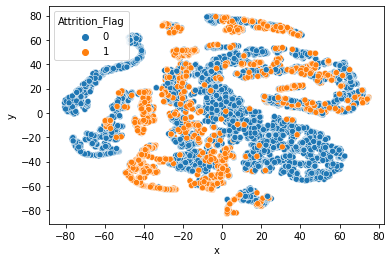

In [ ]:
# t-SNE를 사용한 시각화
from itertools import cycle
tsnedf = df2.copy()

model = TSNE(learning_rate=100)
tsne_features = model.fit_transform(tsnedf)
tsne_features[1:4,:]

tsnedf['x'] = tsne_features[:,0]
tsnedf['y'] = tsne_features[:,1]

sns.scatterplot(x="x", y="y", hue="Attrition_Flag", data=tsnedf)
plt.show()

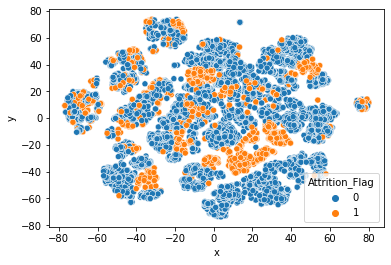

In [ ]:
# t-SNE를 사용한 시각화 (Standard Scaling 적용)
from itertools import cycle
tsnedf = df2.copy()

standard_scaler = StandardScaler()
tsnedf_std = standard_scaler.fit_transform(tsnedf)

model = TSNE(learning_rate=100)
tsne_features = model.fit_transform(tsnedf_std)

tsnedf['x'] = tsne_features[:,0]
tsnedf['y'] = tsne_features[:,1]

sns.scatterplot(x="x", y="y", hue="Attrition_Flag", data=tsnedf)
plt.show()

## 2) 종속변수 분포 확인

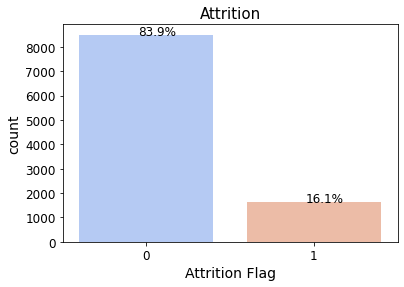

In [ ]:
# 종속변수 분포 확인
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Attrition_Flag' , data=df ,palette='coolwarm')
plt.xticks(size = 12)
plt.xlabel('Attrition Flag', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.yticks(size = 12)
plt.title("Attrition", size = 15)
precent_maker(ax, df.Attrition_Flag)

## 3) 설명변수 분포 확인

In [ ]:
# 'Age_Category' 데이터타입을 'object'로 변경
df = df.astype({'Age_Category': 'object'})
df = df.astype({'Gender': 'object'})

In [ ]:
#범주형 변수와 연속형 변수 구분
num = df.select_dtypes('number').columns.to_list()
del num[0] #Attrition_Flag 제거
cat = df.select_dtypes('object').columns.to_list()

In [ ]:
#시각화 위한 컬럼 percentage 계산 함수
def precent_maker(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

### a. 설명변수 중 범주형 변수의 분포 확인

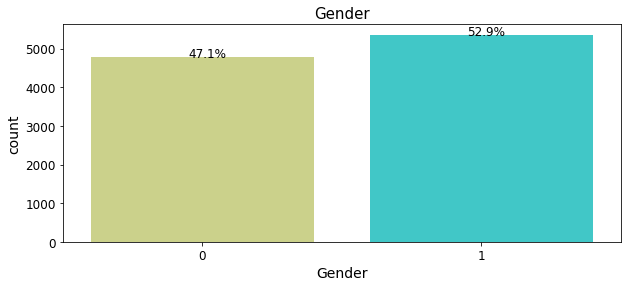

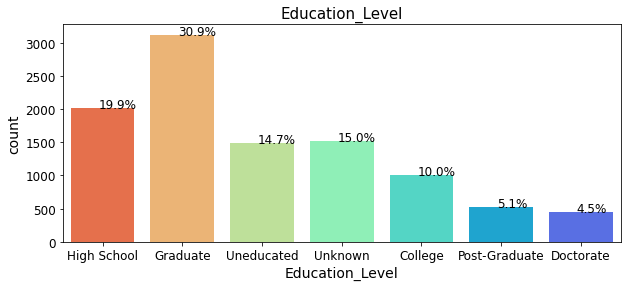

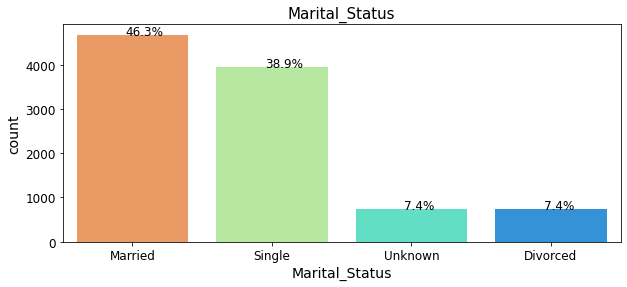

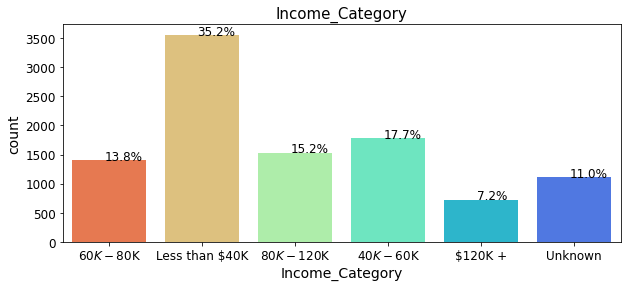

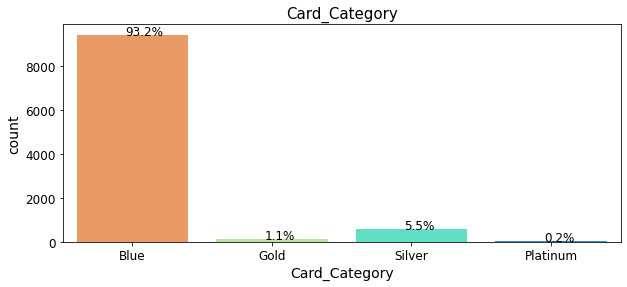

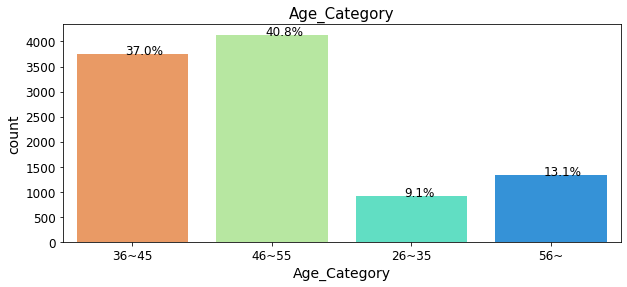

In [ ]:
# 설명변수 중 범주형 변수 분포 확인
for i in cat:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=df ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    precent_maker(ax, df[i])

### b. Attrition 여부에 따른 범주형 설명변수의 분포 (피드백 이전 코드)

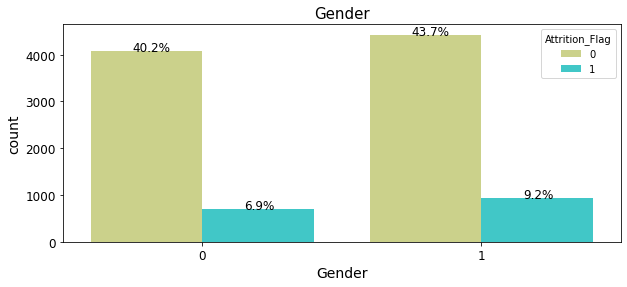

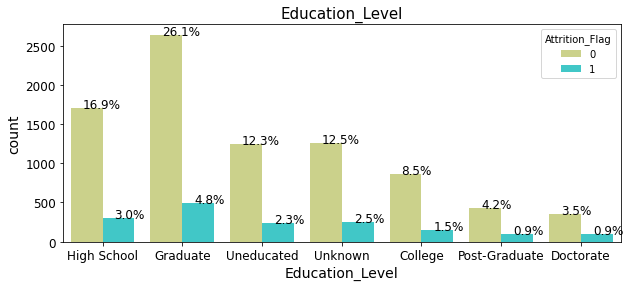

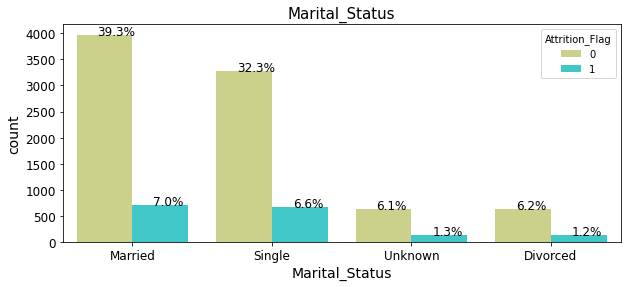

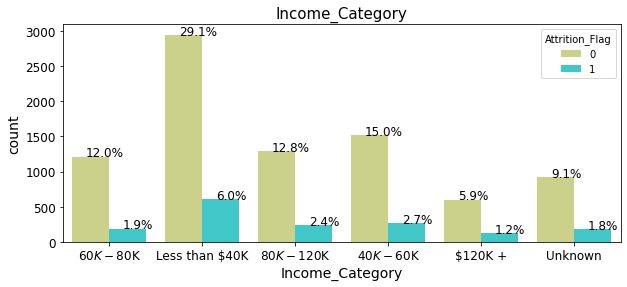

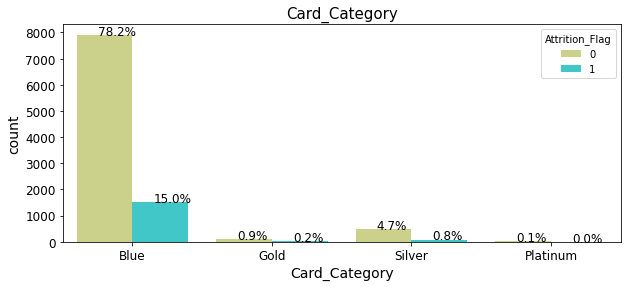

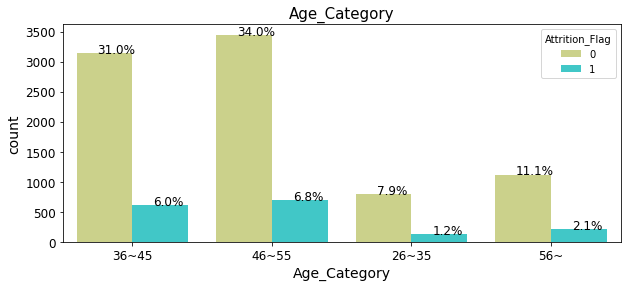

In [ ]:
# Attrition 여부에 따른 범주형 설명변수의 분포
for i in cat:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=df, hue = 'Attrition_Flag' ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    precent_maker(ax, df[i])

### c. 범주형 설명변수에 대하여 속성별 해지율 그래프 그리기 (피드백 이후 추가 코드)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  int64   
 1   Gender                    10127 non-null  int64   
 2   Dependent_count           10127 non-null  int64   
 3   Education_Level           10127 non-null  object  
 4   Marital_Status            10127 non-null  object  
 5   Income_Category           10127 non-null  object  
 6   Card_Category             10127 non-null  object  
 7   Months_on_book            10127 non-null  int64   
 8   Total_Relationship_Count  10127 non-null  int64   
 9   Months_Inactive_12_mon    10127 non-null  int64   
 10  Contacts_Count_12_mon     10127 non-null  int64   
 11  Credit_Limit              10127 non-null  float64 
 12  Total_Revolving_Bal       10127 non-null  int64   
 13  Avg_Open_To_Buy           10127 non-null  floa

In [11]:
# 범주형 설명변수들로만 구성된 데이터프레임 만들기
# 주의: 종속변수인 Attrition_Flag도 빼먹지 말고 넣어주기
df_cat = df.iloc[:,[0,1,3,4,5,6,19]]   
df_cat.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Age_Category
0,0,0,High School,Married,$60K - $80K,Blue,36~45
1,0,1,Graduate,Single,Less than $40K,Blue,46~55
2,0,0,Graduate,Married,$80K - $120K,Blue,46~55
3,0,1,High School,Unknown,Less than $40K,Blue,36~45
4,0,0,Uneducated,Married,$60K - $80K,Blue,36~45


In [13]:
# Gender 컬럼을 문자값으로 변경해주기
df_cat['Gender'] = df_cat['Gender'].replace({0: 'Male', 1: 'Female'})
df_cat.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [14]:
# value count를 위한 임시 컬럼 추가
df_cat['Count'] = 1
df_cat.head()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Age_Category,Count
0,0,Male,High School,Married,$60K - $80K,Blue,36~45,1
1,0,Female,Graduate,Single,Less than $40K,Blue,46~55,1
2,0,Male,Graduate,Married,$80K - $120K,Blue,46~55,1
3,0,Female,High School,Unknown,Less than $40K,Blue,36~45,1
4,0,Male,Uneducated,Married,$60K - $80K,Blue,36~45,1


In [15]:
# 피벗 테이블 생성
att_gender = df_cat.pivot_table(index=df_cat['Gender'], aggfunc='sum')
att_education = df_cat.pivot_table(index=df_cat['Education_Level'], aggfunc='sum')
att_marital = df_cat.pivot_table(index=df_cat['Marital_Status'], aggfunc='sum')
att_income = df_cat.pivot_table(index=df_cat['Income_Category'], aggfunc='sum')
att_card = df_cat.pivot_table(index=df_cat['Card_Category'], aggfunc='sum')
att_age = df_cat.pivot_table(index=df_cat['Age_Category'], aggfunc='sum')

In [16]:
# 해지율 컬럼 추가 & 높은 순서대로 정렬
att_list = [att_gender, att_education, att_marital, att_income, att_card, att_age]

for i in att_list:
    i['Ratio'] = round(i['Attrition_Flag'] / i['Count'] * 100, 2)
    i.sort_values(by=['Ratio'], ascending=False, inplace=True)
    print(i, '\n')

        Attrition_Flag  Count  Ratio
Gender                              
Female             930   5358  17.36
Male               697   4769  14.62 

                 Attrition_Flag  Count  Ratio
Education_Level                              
Doctorate                    95    451  21.06
Post-Graduate                92    516  17.83
Unknown                     256   1519  16.85
Uneducated                  237   1487  15.94
Graduate                    487   3128  15.57
College                     154   1013  15.20
High School                 306   2013  15.20 

                Attrition_Flag  Count  Ratio
Marital_Status                              
Unknown                    129    749  17.22
Single                     668   3943  16.94
Divorced                   121    748  16.18
Married                    709   4687  15.13 

                 Attrition_Flag  Count  Ratio
Income_Category                              
$120K +                     126    727  17.33
Less than $40K          

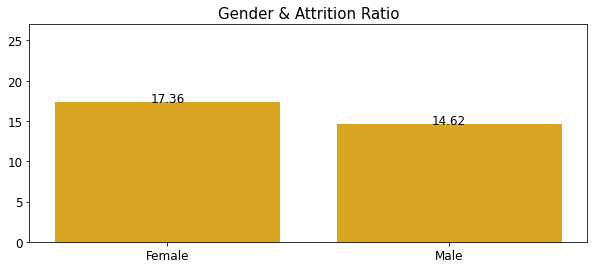

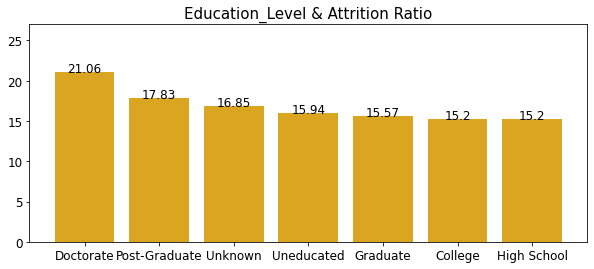

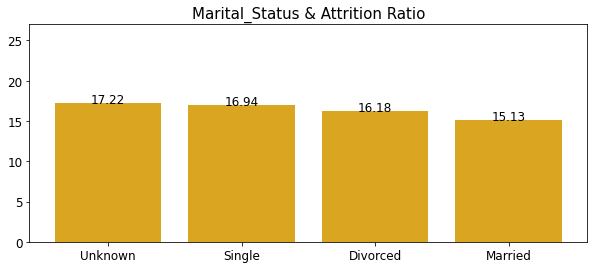

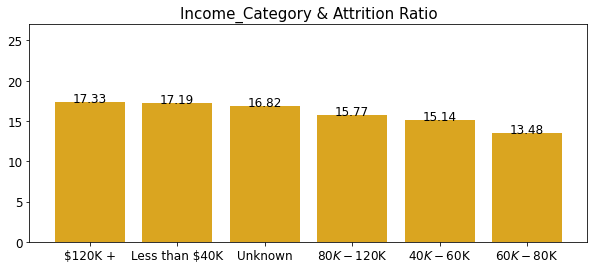

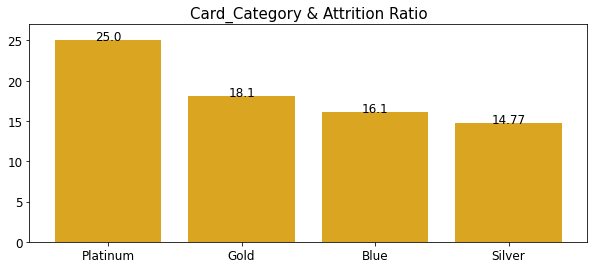

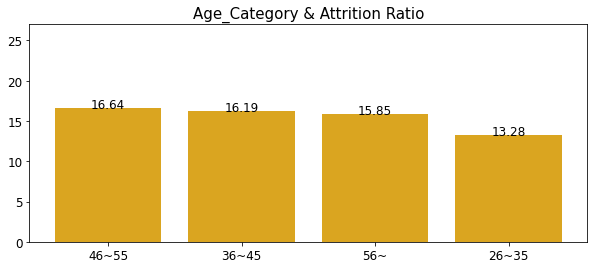

In [17]:
# 그래프 그리기
title_list = ['Gender & Attrition Ratio', 
              'Education_Level & Attrition Ratio',
              'Marital_Status & Attrition Ratio',
              'Income_Category & Attrition Ratio',
              'Card_Category & Attrition Ratio',
              'Age_Category & Attrition Ratio']

for i, j in zip(att_list, title_list):
  
    plt.figure(figsize=(10, 4))
    plt.title(j, size=15)
    plt.bar(i.index, i['Ratio'], color='goldenrod')
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.ylim([0, 27])
    
    text = i['Ratio']
    for k in range(text.shape[0]):
        plt.text(k, text[k], text[k],
                 ha='center', fontsize=12)

    #plt.savefig(j)
    plt.show()

### d. 연속형 설명변수의 분포 시각화

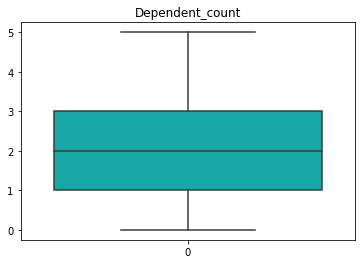

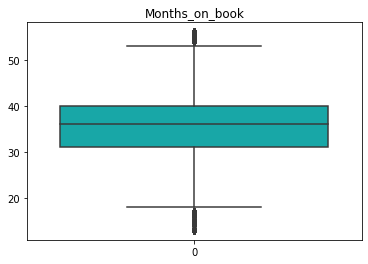

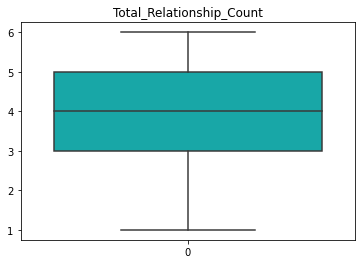

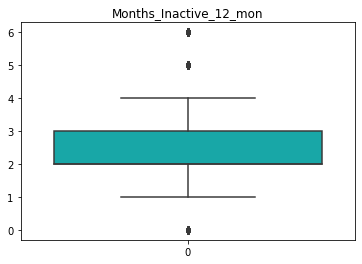

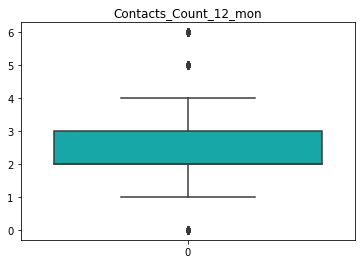

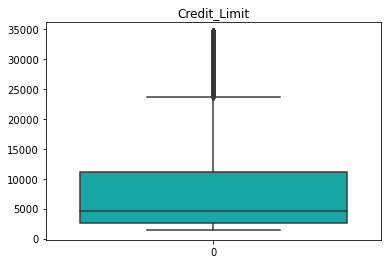

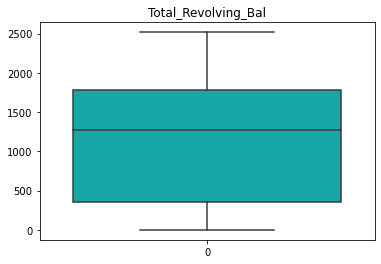

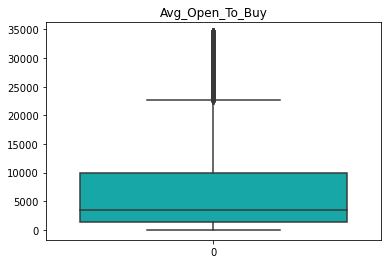

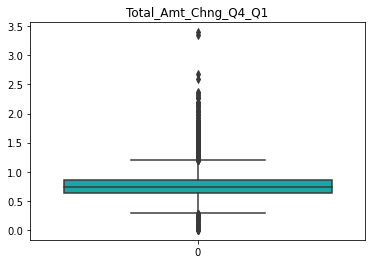

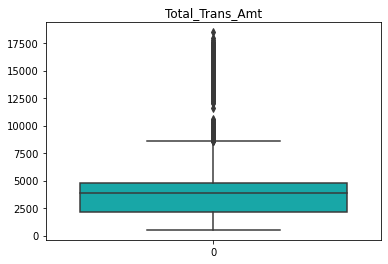

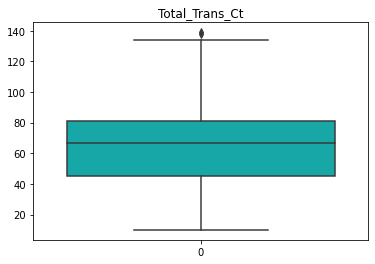

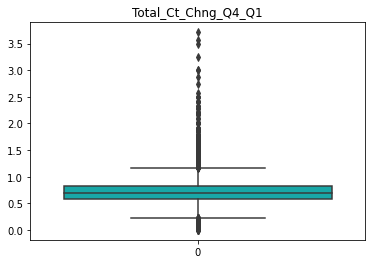

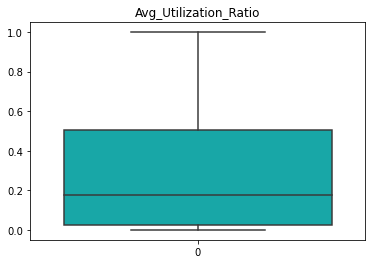

In [ ]:
# 연속형 설명변수 분포 (Box Plot)
for numeric in df[num]:
    sns.boxplot(data=df[numeric],orient="v", color = 'c')
    plt.title(numeric)
    plt.show()

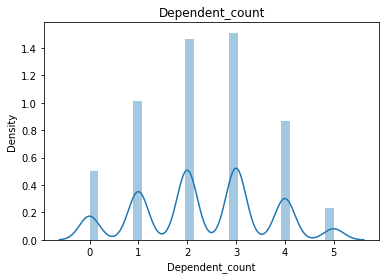

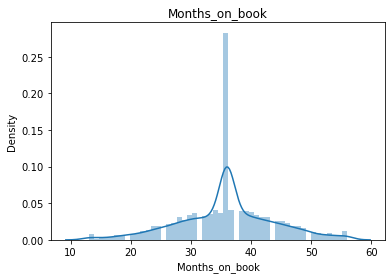

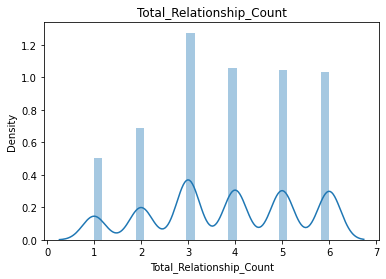

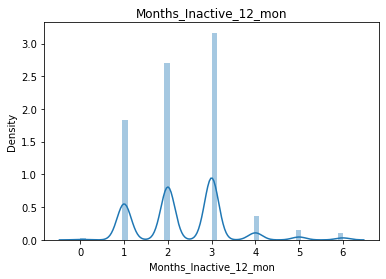

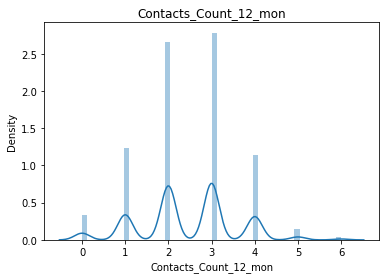

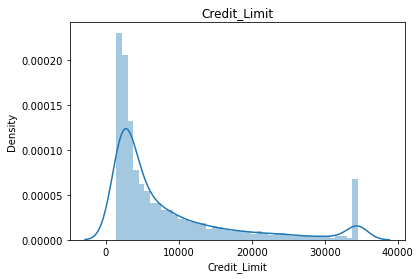

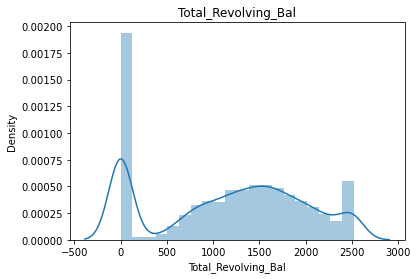

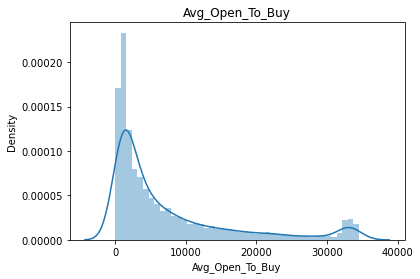

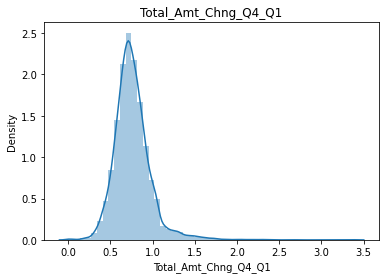

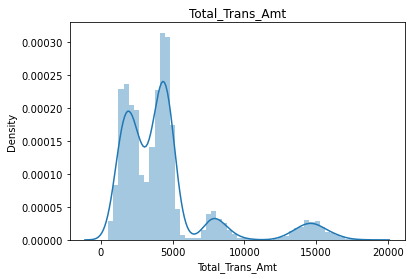

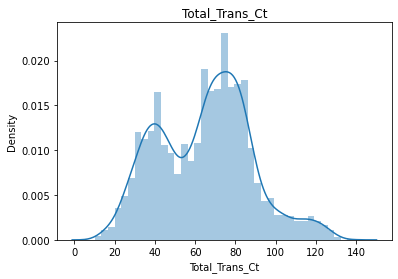

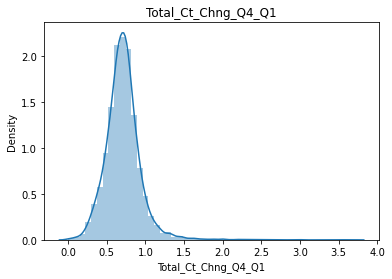

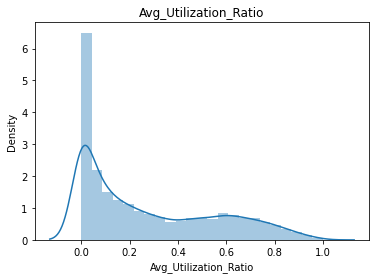

In [ ]:
# 연속형 설명변수 분포 (히스토그램)
for numeric in df[num]:
    sns.distplot(df[numeric])
    plt.title(numeric)
    plt.show()

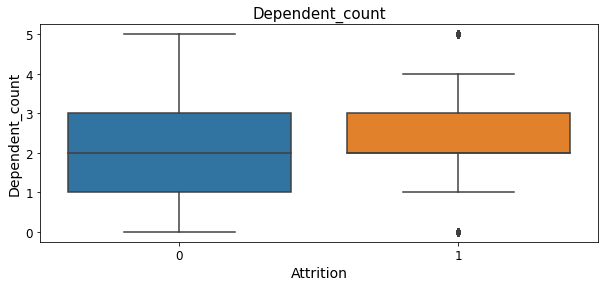

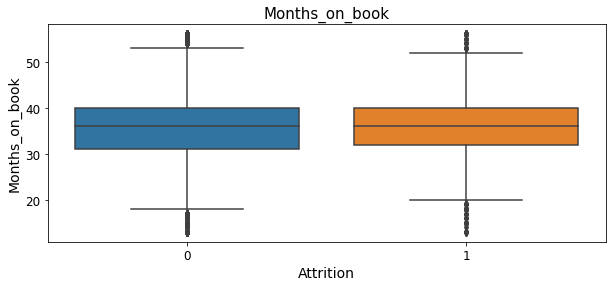

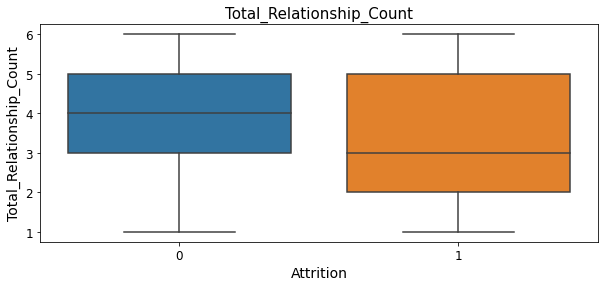

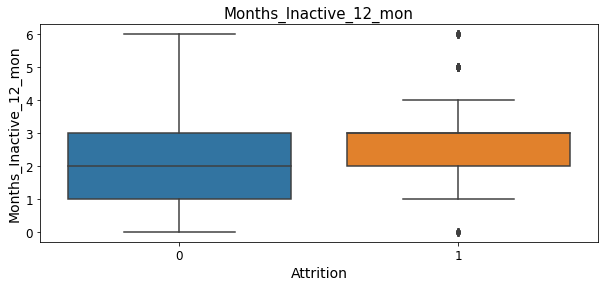

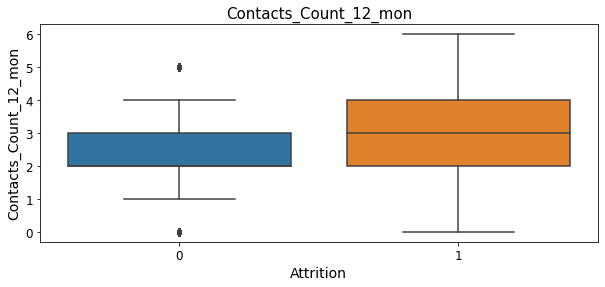

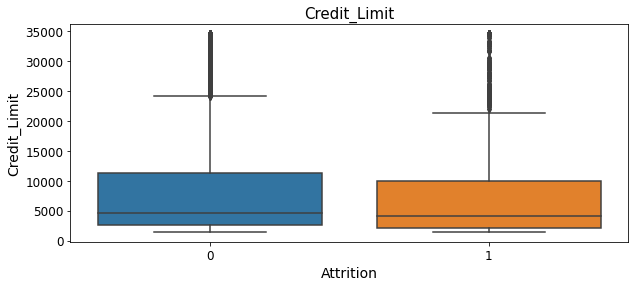

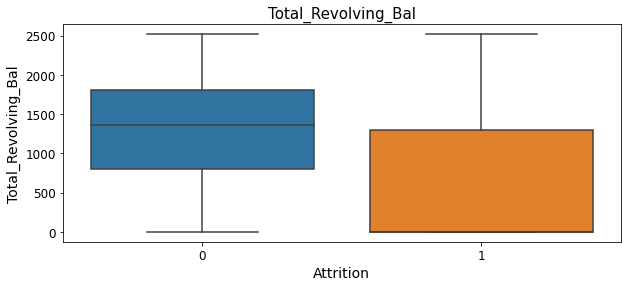

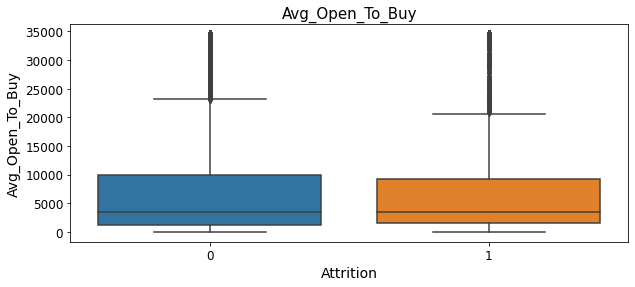

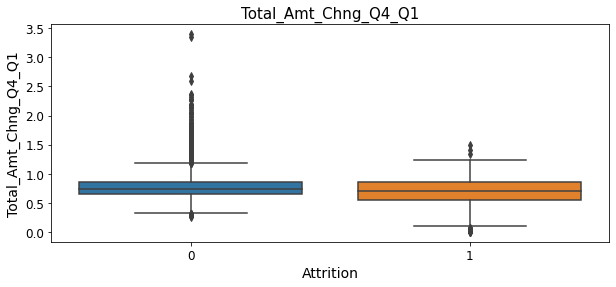

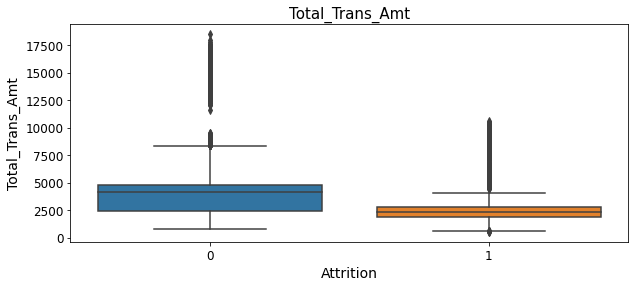

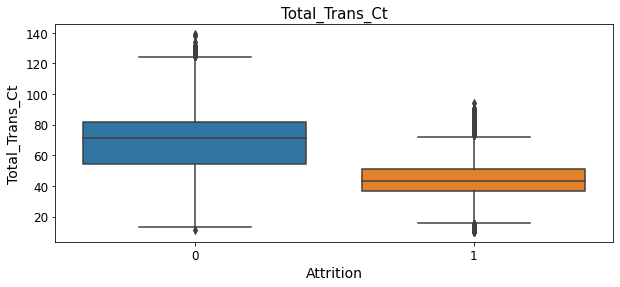

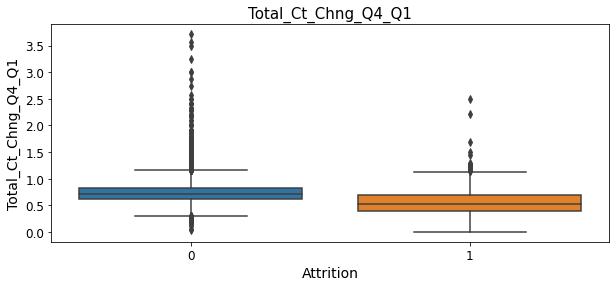

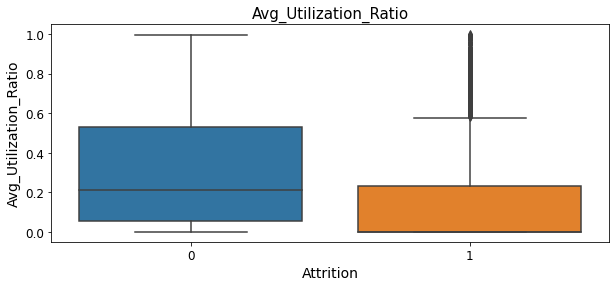

In [ ]:
# Attition 여부에 따른 연속형 설명변수 분포 
for i in num:
    plt.figure(figsize=(10,4))
    ax = sns.boxplot(x='Attrition_Flag', y=i, data=df)
    plt.xticks(size = 12)
    plt.xlabel('Attrition', fontsize=14)
    plt.ylabel(i, fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)

# 4. 전처리

## 1) 차원축소

In [ ]:
# 설명변수와 종속변수 설정
X = df2.drop('Attrition_Flag', axis=1)
y = df2['Attrition_Flag']

X.columns

Index(['Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Age_36~45', 'Age_46~55', 'Age_56~', 'Edu_Doctorate', 'Edu_Graduate',
       'Edu_High School', 'Edu_Post-Graduate', 'Edu_Uneducated', 'Edu_Unknown',
       'Status_Married', 'Status_Single', 'Status_Unknown',
       'Income_$40K - $60K', 'Income_$60K - $80K', 'Income_$80K - $120K',
       'Income_Less than $40K', 'Income_Unknown', 'Card_Gold', 'Card_Platinum',
       'Card_Silver'],
      dtype='object')

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

##랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
## 데이터 분할 함수
from sklearn.model_selection import train_test_split
## 그리드서치
from sklearn.model_selection import GridSearchCV

from sklearn import tree

## 분류 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tools.eval_measures import rmse

In [ ]:
! pip install xgboost

In [ ]:
import xgboost as xgb

### PCA

In [ ]:
# 설명변수 표준화
scaler_min = MinMaxScaler()
scaler_min.fit(X)
X_scaled = scaler_min.transform(X)

In [ ]:
# 90%
pca = PCA(0.9)
X_reduced_pca = pca.fit_transform(X_scaled)

In [ ]:
pd.DataFrame(X_reduced_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.787192,-0.427302,0.913997,-0.576438,-0.133335,0.218745,-0.672151,-0.150326,0.011535,0.761263,-0.015035,-0.217245,-0.081735,0.207412,-0.107571,-0.143237,-0.045360
1,-0.710790,0.494051,-0.840627,0.783558,-0.398401,-0.089737,-0.187495,-0.058643,0.002407,0.092924,-0.184444,-0.387755,-0.061669,0.433937,-0.080115,-0.504894,0.032940
2,0.752304,-0.838328,-0.432032,0.777827,-0.263408,-0.001838,-0.105127,0.045236,-0.066852,-0.273141,-0.439095,-0.617791,-0.054334,-0.467105,-0.064104,-0.098690,0.074263
3,-0.890991,0.194447,0.712952,-0.584132,-0.315691,0.001883,-0.796682,-0.333189,0.125997,-0.324001,0.322783,0.257761,1.019008,0.002553,-0.103042,-0.316033,-0.351781
4,0.668663,-0.409698,0.960364,-0.332333,-0.185574,0.004268,0.475199,-0.251262,0.739031,0.910439,-0.272891,-0.390592,-0.093674,-0.043718,-0.163554,-0.015366,0.092571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.387188,0.540733,-0.792213,0.757684,0.718779,-0.399658,-0.228529,-0.560816,0.076625,-0.255032,-0.124118,0.462760,-0.201628,-0.145492,-0.079942,0.218824,0.371342
10123,0.362865,0.258903,0.751361,-0.347975,0.595845,-0.475579,0.427927,-0.797165,-0.551558,-0.337409,0.062266,0.228538,0.313521,0.061189,-0.168787,0.284498,0.039350
10124,-0.707685,-0.430365,0.821278,-0.571833,-0.407005,0.124569,-0.610745,0.404871,-0.151548,0.211562,-0.506371,-0.139044,-0.108901,0.142528,-0.108504,0.279289,0.162879
10125,0.487603,0.117566,0.093804,0.727421,0.726376,-0.197548,-0.034915,0.041339,-0.085018,0.068278,-0.731902,0.190673,1.087561,-0.093054,-0.069016,0.292954,0.082867


In [ ]:
a = {'PCA_1':X_reduced_pca[:,0], 'PCA_2':X_reduced_pca[:,1], 'PCA_3':X_reduced_pca[:,2], 'PCA_4':X_reduced_pca[:,3],
     'PCA_5':X_reduced_pca[:,4], 'PCA_6':X_reduced_pca[:,5], 'PCA_7':X_reduced_pca[:,6], 'PCA_8':X_reduced_pca[:,7],
     'PCA_9':X_reduced_pca[:,8], 'PCA_10':X_reduced_pca[:,9], 'PCA_11':X_reduced_pca[:,10], 'PCA_12':X_reduced_pca[:,11],
     'PCA_13':X_reduced_pca[:,12], 'PCA_14':X_reduced_pca[:,13], 'PCA_15':X_reduced_pca[:,14], 
     'PCA_16':X_reduced_pca[:,15], 'PCA_17':X_reduced_pca[:,16], 'attrition':df2['Attrition_Flag']}
data = pd.DataFrame(a)

In [ ]:
data.to_csv('PCA_0.9.csv',header=True, index=False)

In [ ]:
# 95%
pca = PCA(0.95)
X_reduced_pca = pca.fit_transform(X_scaled)

In [ ]:
pd.DataFrame(X_reduced_pca)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.787192,-0.427302,0.913997,-0.576438,-0.133335,0.218745,-0.672151,-0.150326,0.011535,0.761263,...,-0.217245,-0.081735,0.207412,-0.107571,-0.143237,-0.045360,-0.034241,-0.135122,-0.073484,-0.087755
1,-0.710790,0.494051,-0.840627,0.783558,-0.398401,-0.089737,-0.187495,-0.058643,0.002407,0.092924,...,-0.387755,-0.061669,0.433937,-0.080115,-0.504894,0.032940,-0.037407,0.133936,0.059388,-0.157226
2,0.752304,-0.838328,-0.432032,0.777827,-0.263408,-0.001838,-0.105127,0.045236,-0.066852,-0.273141,...,-0.617791,-0.054334,-0.467105,-0.064104,-0.098690,0.074263,-0.010902,-0.135334,0.164917,0.070001
3,-0.890991,0.194447,0.712952,-0.584132,-0.315691,0.001883,-0.796682,-0.333189,0.125997,-0.324001,...,0.257761,1.019008,0.002553,-0.103042,-0.316033,-0.351781,-0.175764,-0.006854,-0.032693,0.053218
4,0.668663,-0.409698,0.960364,-0.332333,-0.185574,0.004268,0.475199,-0.251262,0.739031,0.910439,...,-0.390592,-0.093674,-0.043718,-0.163554,-0.015366,0.092571,-0.011088,-0.149497,0.139140,-0.065397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.387188,0.540733,-0.792213,0.757684,0.718779,-0.399658,-0.228529,-0.560816,0.076625,-0.255032,...,0.462760,-0.201628,-0.145492,-0.079942,0.218824,0.371342,0.224977,0.330431,-0.115913,0.154344
10123,0.362865,0.258903,0.751361,-0.347975,0.595845,-0.475579,0.427927,-0.797165,-0.551558,-0.337409,...,0.228538,0.313521,0.061189,-0.168787,0.284498,0.039350,0.062800,0.284583,-0.051704,0.082733
10124,-0.707685,-0.430365,0.821278,-0.571833,-0.407005,0.124569,-0.610745,0.404871,-0.151548,0.211562,...,-0.139044,-0.108901,0.142528,-0.108504,0.279289,0.162879,0.102764,-0.074962,-0.242794,0.041381
10125,0.487603,0.117566,0.093804,0.727421,0.726376,-0.197548,-0.034915,0.041339,-0.085018,0.068278,...,0.190673,1.087561,-0.093054,-0.069016,0.292954,0.082867,0.027583,0.370260,0.220828,-0.049571


In [ ]:
a = {'PCA_1':X_reduced_pca[:,0], 'PCA_2':X_reduced_pca[:,1], 'PCA_3':X_reduced_pca[:,2], 'PCA_4':X_reduced_pca[:,3],
     'PCA_5':X_reduced_pca[:,4], 'PCA_6':X_reduced_pca[:,5], 'PCA_7':X_reduced_pca[:,6], 'PCA_8':X_reduced_pca[:,7],
     'PCA_9':X_reduced_pca[:,8], 'PCA_10':X_reduced_pca[:,9], 'PCA_11':X_reduced_pca[:,10], 'PCA_12':X_reduced_pca[:,11],
     'PCA_13':X_reduced_pca[:,12], 'PCA_14':X_reduced_pca[:,13], 'PCA_15':X_reduced_pca[:,14], 
     'PCA_16':X_reduced_pca[:,15], 'PCA_17':X_reduced_pca[:,16], 'PCA_18':X_reduced_pca[:,17], 'PCA_19':X_reduced_pca[:,18],
     'PCA_20':X_reduced_pca[:,19], 'PCA_21':X_reduced_pca[:,20], 'attrition':df2['Attrition_Flag']}
data=pd.DataFrame(a)

data.to_csv('PCA_0.95.csv',header=True, index=False)

In [ ]:
# 99%
pca = PCA(0.99)
X_reduced_pca = pca.fit_transform(X_scaled)

In [ ]:
pd.DataFrame(X_reduced_pca)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.787192,-0.427302,0.913997,-0.576438,-0.133335,0.218745,-0.672151,-0.150326,0.011535,0.761263,...,-0.034241,-0.135122,-0.073484,-0.087755,0.014752,-0.242339,-0.010589,-0.001678,-0.014764,0.040102
1,-0.710790,0.494051,-0.840627,0.783558,-0.398401,-0.089737,-0.187495,-0.058643,0.002407,0.092924,...,-0.037407,0.133936,0.059388,-0.157226,-0.174848,-0.211136,-0.022614,-0.124362,-0.001933,0.049797
2,0.752304,-0.838328,-0.432032,0.777827,-0.263408,-0.001838,-0.105127,0.045236,-0.066852,-0.273141,...,-0.010902,-0.135334,0.164917,0.070001,-0.503889,-0.175712,-0.017782,-0.063002,-0.024473,0.051597
3,-0.890991,0.194447,0.712952,-0.584132,-0.315691,0.001883,-0.796682,-0.333189,0.125997,-0.324001,...,-0.175764,-0.006854,-0.032693,0.053218,-0.256960,0.285119,-0.195444,-0.026488,-0.027983,0.020476
4,0.668663,-0.409698,0.960364,-0.332333,-0.185574,0.004268,0.475199,-0.251262,0.739031,0.910439,...,-0.011088,-0.149497,0.139140,-0.065397,-0.523048,-0.134336,-0.053320,-0.015467,-0.040083,-0.008942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.387188,0.540733,-0.792213,0.757684,0.718779,-0.399658,-0.228529,-0.560816,0.076625,-0.255032,...,0.224977,0.330431,-0.115913,0.154344,0.258593,-0.098742,-0.022108,-0.045960,-0.010650,0.046944
10123,0.362865,0.258903,0.751361,-0.347975,0.595845,-0.475579,0.427927,-0.797165,-0.551558,-0.337409,...,0.062800,0.284583,-0.051704,0.082733,0.113484,-0.041701,0.490787,-0.057852,-0.052782,0.034628
10124,-0.707685,-0.430365,0.821278,-0.571833,-0.407005,0.124569,-0.610745,0.404871,-0.151548,0.211562,...,0.102764,-0.074962,-0.242794,0.041381,0.341998,0.024162,-0.022831,-0.043947,-0.030341,0.007314
10125,0.487603,0.117566,0.093804,0.727421,0.726376,-0.197548,-0.034915,0.041339,-0.085018,0.068278,...,0.027583,0.370260,0.220828,-0.049571,0.076465,0.168788,-0.202395,-0.045082,-0.012832,0.127913


In [ ]:
a = {'PCA_1':X_reduced_pca[:,0], 'PCA_2':X_reduced_pca[:,1], 'PCA_3':X_reduced_pca[:,2], 'PCA_4':X_reduced_pca[:,3],
     'PCA_5':X_reduced_pca[:,4], 'PCA_6':X_reduced_pca[:,5], 'PCA_7':X_reduced_pca[:,6], 'PCA_8':X_reduced_pca[:,7],
     'PCA_9':X_reduced_pca[:,8], 'PCA_10':X_reduced_pca[:,9], 'PCA_11':X_reduced_pca[:,10], 'PCA_12':X_reduced_pca[:,11],
     'PCA_13':X_reduced_pca[:,12], 'PCA_14':X_reduced_pca[:,13], 'PCA_15':X_reduced_pca[:,14], 
     'PCA_16':X_reduced_pca[:,15], 'PCA_17':X_reduced_pca[:,16], 'PCA_18':X_reduced_pca[:,17], 'PCA_19':X_reduced_pca[:,18],
     'PCA_20':X_reduced_pca[:,19], 'PCA_21':X_reduced_pca[:,20], 'PCA_22':X_reduced_pca[:,21], 'PCA_23':X_reduced_pca[:,22],
     'PCA_24':X_reduced_pca[:,23], 'PCA_25':X_reduced_pca[:,24],
     'PCA_26':X_reduced_pca[:,25], 'PCA_27':X_reduced_pca[:,26], 'attrition':df2['Attrition_Flag']}
data=pd.DataFrame(a)

data.to_csv('PCA_0.99.csv',header=True, index=False)

## 2) Kernel PCA

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

In [ ]:
# linear
kpca_linear = KernelPCA(n_components = 21, kernel="linear", fit_inverse_transform=True)
X_reduced_linear= kpca_linear.fit_transform(X_scaled)

In [ ]:
kpca_lin = pd.DataFrame(X_reduced_linear)
a = pd.concat([kpca_lin,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('kernel_linear.csv',header=True, index=False)

In [ ]:
# rbf
kpca_rbf = KernelPCA(n_components = 21, kernel="rbf", fit_inverse_transform=True)
X_reduced_rbf= kpca_rbf.fit_transform(X_scaled)

In [ ]:
kpca_rbf_ = pd.DataFrame(X_reduced_rbf)
a = pd.concat([kpca_rbf_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('kernel_rbf.csv',header=True, index=False)

## 3) LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle = LocallyLinearEmbedding(n_components=21, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_scaled)

In [ ]:
lle_ = pd.DataFrame(X_reduced_lle)
a = pd.concat([lle_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('LLE.csv',header=True, index=False)

## 4) T-SNE

In [ ]:
# TSNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_scaled)

a={'tsne_1':X_reduced_tsne[:,0],'tsne_2':X_reduced_tsne[:,1],'tsne_3':X_reduced_tsne[:,2], 'attrition':df2['Attrition_Flag']}

data=pd.DataFrame(a)

data.to_csv('TSNE.csv',header=True, index=False)

## 5) Random Forest Feature Selection

In [ ]:
rf_clf=RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
rf_clf.fit(X_scaled,y)

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=rf_clf.feature_importances_
feature_importance.sort_values(by="importance",ascending=False).head(21)

,feature,importance
11,Total_Trans_Ct,0.193373
10,Total_Trans_Amt,0.184833
7,Total_Revolving_Bal,0.159976
12,Total_Ct_Chng_Q4_Q1,0.144971
13,Avg_Utilization_Ratio,0.092713
3,Total_Relationship_Count,0.057176
9,Total_Amt_Chng_Q4_Q1,0.048218
5,Contacts_Count_12_mon,0.032709
4,Months_Inactive_12_mon,0.025874
6,Credit_Limit,0.025021


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(21)
col = fi.feature.values
rf_ = pd.DataFrame(X[col])
a = pd.concat([rf_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('RANDOMFOREST.csv',header=True, index=False)

## 6) XGBoost Feature Selection

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)
xgb_clf.fit(X_scaled, y)

[11:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=xgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False).head(21)

,feature,importance
11,Total_Trans_Ct,0.202458
7,Total_Revolving_Bal,0.171882
3,Total_Relationship_Count,0.112535
10,Total_Trans_Amt,0.058136
12,Total_Ct_Chng_Q4_Q1,0.046002
0,Gender,0.041516
4,Months_Inactive_12_mon,0.041150
9,Total_Amt_Chng_Q4_Q1,0.033616
5,Contacts_Count_12_mon,0.026892
2,Months_on_book,0.024192


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(21)
col = fi.feature.values
xgb_ = pd.DataFrame(X[col])
a = pd.concat([xgb_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('XGB.csv',header=True, index=False)

## 7) LGBM

In [ ]:
! pip install lightgbm

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
lgb_clf=LGBMClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)

lgb_clf.fit(X_scaled,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(learning_rate=0.2, max_depth=5, random_state=42)

In [ ]:
## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X.columns
feature_importance["importance"]=lgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False).head(21)

,feature,importance
10,Total_Trans_Amt,448
9,Total_Amt_Chng_Q4_Q1,270
11,Total_Trans_Ct,231
12,Total_Ct_Chng_Q4_Q1,225
7,Total_Revolving_Bal,149
2,Months_on_book,134
6,Credit_Limit,114
3,Total_Relationship_Count,104
8,Avg_Open_To_Buy,100
5,Contacts_Count_12_mon,92


In [ ]:
fi = feature_importance.sort_values(by="importance",ascending=False).head(21)
col = fi.feature.values
lgbm_ = pd.DataFrame(X[col])
a = pd.concat([lgbm_,df2['Attrition_Flag']], axis=1)
a = a.rename(columns={'Attrition_Flag': 'attrition'})
data = pd.DataFrame(a)

data.to_csv('LGBM.csv',header=True, index=False)

In [ ]:
# 가공한 원 데이터 (df2) csv 파일로 저장
df2_sub = df2.rename(columns={'Attrition_Flag': 'attrition'}, inplace=False)
df2_sub_cols = ['Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Age_36~45', 'Age_46~55', 'Age_56~', 'Edu_Doctorate', 'Edu_Graduate',
       'Edu_High School', 'Edu_Post-Graduate', 'Edu_Uneducated',
       'Status_Married', 'Status_Single', 'Income_$40K - $60K',
       'Income_$60K - $80K', 'Income_$80K - $120K', 'Income_Less than $40K',
       'Card_Gold', 'Card_Platinum', 'Card_Silver', 'attrition']
df2_sub = df2_sub[df2_sub_cols]
df2_sub.to_csv('BankChurners_.csv',header=True, index=False)

# 5. Modeling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

In [ ]:
lis = ['BankChurners_','PCA_0.9', 'PCA_0.95', 'PCA_0.99', 'kernel_linear', 'kernel_rbf', 
       'LLE', 'TSNE', 'RANDOMFOREST', 'XGB', 'LGBM']

In [ ]:
lists = lis.copy()
for i in range(len(lists)):
  a= lists[i]
  a=a+'.csv'
  lists[i]=pd.read_csv(a)

In [ ]:
# 차원 축소한 데이터프레임 data_name에 저장
data_name = lis.copy()
k=0
for i in lists:
    data_name[k]=pd.DataFrame(i).iloc[:,1:]
    k+=1

In [ ]:
# 차원축소 csv파일 이름으로 dictionary data_dic 생성
data_dic = {}
for key, data in enumerate(lis):
    data_dic[data] = data_name[key]

In [ ]:
# 데이터 y,X로 나눔
X_dic = {}
y_dic = {}
scX=MinMaxScaler()


for key, data in enumerate(lis):
    y_dic[data] = data_dic[data].iloc[:,-1]
    X_dic[data] = data_dic[data].iloc[:,:-1] 
    X_dic[data]=scX.fit_transform(X_dic[data])
    
X_train = {}
X_test = {}
y_train = {}
y_test = {}
# train, test 8:2로 나눔
for i in lis:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X_dic[i], y_dic[i], test_size=0.2, random_state =2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier


Dt = DecisionTreeClassifier(max_depth=7, random_state = 0)
rf = RandomForestClassifier(n_estimators=100)
Logit = LogisticRegression()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=5)
SVC = SVC(kernel="rbf", gamma = 'auto', C=100) #가우시안 rbf 커널
XGB = xgb.XGBClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier()

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report

## 모델, 스코어, 모델명 받아서 스코어 리턴해주는 함수
def evaluate_classifier(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train[i]):
            X_cvtrain, X_cvtest = pd.DataFrame(X_train[i]).iloc[train_index], pd.DataFrame(X_train[i]).iloc[test_index]
            y_cvtrain, y_cvtest = y_train[i].iloc[train_index], y_train[i].iloc[test_index]
#         X_train, X_test = X_train.values, X_test.values
            acc = clf.fit(X_cvtrain, y_cvtrain).score(X_cvtest, y_cvtest)
            y_pred = clf.predict(X_cvtest)
            bal_acc = balanced_accuracy_score(y_cvtest, y_pred)
            rec=recall_score(y_cvtest, y_pred)
            f1=f1_score(y_cvtest,y_pred)
            auc = roc_auc_score(y_cvtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        cv_acc = np.mean(acc_list)
        cv_bal_acc = np.mean(bal_acc_list)
        cv_rec=np.mean(rec_list)
        cv_f1=np.mean(f1_list)
        cv_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [cv_acc, cv_bal_acc, cv_rec, cv_f1, cv_auc]},
            index=['Accuracy', 'Balanced accuracy','Recall','F1score', "auROC"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


# 모델마다 스코어 넣어줌
def see_score(model_list, model_name):

  df_scores = pd.DataFrame()
    
  for index, key in enumerate(model_list):
      df_scores = evaluate_classifier(key, df_scores, model_name[index])
  return df_scores

df_scores = see_score(lists_model, model_names)
df_scores.to_csv('df_scores.csv', index=False)

[11:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# adaboost

def adaboost(X_train, X_test, y_train):
  model = AdaBoostClassifier(n_estimators=100, random_state=42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test) 
  return y_pred

df_majority = {}
df_minority = {}
X_train_sm = {}
y_train_sm = {}
y_baseline = {}
y_smote = {}
X_maj_rus = {}
X_rus= {}
y_rus = {}
X_train_rus = {}
y_train_rus = {}

for data in lis:
  df_majority[data] = data_dic[data][data_dic[data]['attrition']==0]
  
  df_minority[data] = data_dic[data][data_dic[data]['attrition']==1]

  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# SMOTE
  sm = SMOTE(random_state=42)
  # x_train, y_train 데이터를 가지고 smote(up sampling), y_smote[data]는 스모트데이터 adaboost한거
  X_train_sm[data], y_train_sm[data] = sm.fit_sample(X_train[data], y_train[data])
  y_smote[data] = adaboost(X_train_sm[data], X_test[data], y_train_sm[data])

    # RUS
  X_maj_rus[data] = resample(df_majority[data], replace=False, n_samples=len(df_minority[data]),random_state=44)

  X_rus[data] = pd.concat([X_maj_rus[data], df_minority[data]])
  X_train_rus[data] = X_rus[data].drop(['attrition'], axis=1)
  y_train_rus[data] = X_rus[data].attrition
  y_rus[data] = adaboost(X_train_rus[data], X_test[data], y_train_rus[data])

In [ ]:
def evaluate_classifier_rus(clf, df_scores_rus, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_rus[i]):
            X_rustrain, X_rustest = pd.DataFrame(X_train_rus[i]).iloc[train_index], pd.DataFrame(X_train_rus[i]).iloc[test_index]
            y_rustrain, y_rustest = y_train_rus[i].iloc[train_index], y_train_rus[i].iloc[test_index]

            acc = clf.fit(X_rustrain, y_rustrain).score(X_rustest, y_rustest)
            y_pred = clf.predict(X_rustest)
            bal_acc = balanced_accuracy_score(y_rustest, y_pred)
            rec=recall_score(y_rustest, y_pred)
            f1=f1_score(y_rustest,y_pred)
            auc = roc_auc_score(y_rustest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        rus_acc = np.mean(acc_list)
        rus_bal_acc = np.mean(bal_acc_list)
        rus_rec=np.mean(rec_list)
        rus_f1=np.mean(f1_list)
        rus_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [rus_acc, rus_bal_acc, rus_rec, rus_f1, rus_auc]},
            index=['Accuracy_rus', 'Balanced accuracy_rus','Recall_rus','F1score_rus', "auROC_rus"]
        )
        
        #df_scores_rus =[df_scores_rus, clf_score]

        df_scores_rus = pd.concat([df_scores_rus, clf_score], axis=1).round(decimals=3)
    return df_scores_rus

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_rus(model_list, model_name):

    df_scores_rus=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_rus = evaluate_classifier_rus(key, df_scores_rus,model_name[index])
    return df_scores_rus

df_scores_rus = see_score_rus(lists_model, model_names)
df_scores_rus.to_csv('df_scores_rus.csv',index=False)

[11:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_smote(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list=[]

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_sm[i]):
            X_smtrain, X_smtest = pd.DataFrame(X_train_sm[i]).iloc[train_index], pd.DataFrame(X_train_sm[i]).iloc[test_index]
            y_smtrain, y_smtest = y_train_sm[i][train_index], y_train_sm[i][test_index]

            acc = clf.fit(X_smtrain, y_smtrain).score(X_smtest, y_smtest)
            y_pred = clf.predict(X_smtest)
            bal_acc = balanced_accuracy_score(y_smtest, y_pred)
            rec=recall_score(y_smtest, y_pred)
            f1=f1_score(y_smtest,y_pred)
            auc = roc_auc_score(y_smtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        sm_acc = np.mean(acc_list)
        sm_bal_acc = np.mean(bal_acc_list)
        sm_rec=np.mean(rec_list)
        sm_f1=np.mean(f1_list)
        sm_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [sm_acc, sm_bal_acc, sm_rec, sm_f1, sm_auc]},
            index=['Accuracy', 'Balanced accuracy','Recall','F1score', "auROC"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_smote(model_list, model_name):

  df_scores_smote = pd.DataFrame()

  for index, key in enumerate(model_list):
      df_scores_smote = evaluate_classifier_smote(key, df_scores_smote, model_name[index])
  return df_scores_smote

df_scores_smote = see_score_smote(lists_model, model_names)
df_scores_smote.to_csv('df_scores_smote.csv',index=False)

[11:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:51:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# SMOTE, RUS 이외의 샘플링 기법 적용
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

In [ ]:
# Near Miss Undersampling, CondensedNearestNeighbour, One Sided Selection
y_baseline = {}
X_train_nm = {}
y_train_nm= {}
y_nm = {}
X_train_cnn = {}
y_train_cnn= {}
y_cnn = {}
X_train_oss = {}
y_train_oss= {}
y_oss = {}

for data in lis:
  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# Near Miss
  nm = NearMiss()
  X_train_nm[data], y_train_nm[data] = nm.fit_sample(X_train[data], y_train[data])
  y_nm[data] = adaboost(X_train_nm[data], X_test[data], y_train_nm[data])

# CondensedNearestNeighbour
  cnn =  CondensedNearestNeighbour()
  X_train_cnn[data], y_train_cnn[data] = cnn.fit_sample(X_train[data], y_train[data])
  y_cnn[data] = adaboost(X_train_cnn[data], X_test[data], y_train_cnn[data])

# OneSidedSelection
  oss = OneSidedSelection(random_state=7)
  X_train_oss[data], y_train_oss[data] = oss.fit_sample(X_train[data], y_train[data])
  y_oss[data] = adaboost(X_train_oss[data], X_test[data], y_train_oss[data])

In [ ]:
# ROS, ADASYN, SMOTE+Tomek
y_baseline = {}
X_train_ros = {}
y_train_ros = {}
y_ros = {}
X_train_ada = {}
y_train_ada = {}
y_ada = {}
X_train_smt = {}
y_train_smt= {}
y_smt = {}

for data in lis:
  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# ROS
  ros = RandomOverSampler(random_state=7)
  X_train_ros[data], y_train_ros[data] = ros.fit_sample(X_train[data], y_train[data])
  y_ros[data] = adaboost(X_train_ros[data], X_test[data], y_train_ros[data])

# ADASYN
  ada =  ADASYN(random_state=7)
  X_train_ada[data], y_train_ada[data] = ada.fit_sample(X_train[data], y_train[data])
  y_ada[data] = adaboost(X_train_ada[data], X_test[data], y_train_ada[data])

# SMOTE+Tomek
  smt = SMOTETomek(random_state=7)
  X_train_smt[data], y_train_smt[data] = smt.fit_sample(X_train[data], y_train[data])
  y_smt[data] = adaboost(X_train_smt[data], X_test[data], y_train_smt[data])

In [ ]:
def evaluate_classifier_nm(clf, df_scores_nm, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_nm[i]):
            X_nmtrain, X_nmtest = pd.DataFrame(X_train_nm[i]).iloc[train_index], pd.DataFrame(X_train_nm[i]).iloc[test_index]
            y_nmtrain, y_nmtest = y_train_nm[i].iloc[train_index], y_train_nm[i].iloc[test_index]

            acc = clf.fit(X_nmtrain, y_nmtrain).score(X_nmtest, y_nmtest)
            y_pred = clf.predict(X_nmtest)
            bal_acc = balanced_accuracy_score(y_nmtest, y_pred)
            rec=recall_score(y_nmtest, y_pred)
            f1=f1_score(y_nmtest,y_pred)
            auc = roc_auc_score(y_nmtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        nm_acc = np.mean(acc_list)
        nm_bal_acc = np.mean(bal_acc_list)
        nm_rec=np.mean(rec_list)
        nm_f1=np.mean(f1_list)
        nm_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [nm_acc, nm_bal_acc, nm_rec, nm_f1, nm_auc]},
            index=['Accuracy_nm', 'Balanced accuracy_nm','Recall_nm','F1score_nm', "auROC_nm"]
        )
        
        

        df_scores_nm = pd.concat([df_scores_nm, clf_score], axis=1).round(decimals=3)
    return df_scores_nm

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_nm(model_list, model_name):

    df_scores_nm=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_nm = evaluate_classifier_nm(key, df_scores_nm, model_name[index])
    return df_scores_nm

df_scores_nm = see_score_nm(lists_model, model_names)
df_scores_nm.to_csv('df_scores_nm.csv')

[13:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
def evaluate_classifier_cnn(clf, df_scores_cnn, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_cnn[i]):
            X_cnntrain, X_cnntest = pd.DataFrame(X_train_cnn[i]).iloc[train_index], pd.DataFrame(X_train_cnn[i]).iloc[test_index]
            y_cnntrain, y_cnntest = y_train_cnn[i].iloc[train_index], y_train_cnn[i].iloc[test_index]

            acc = clf.fit(X_cnntrain, y_cnntrain).score(X_cnntest, y_cnntest)
            y_pred = clf.predict(X_cnntest)
            bal_acc = balanced_accuracy_score(y_cnntest, y_pred)
            rec=recall_score(y_cnntest, y_pred)
            f1=f1_score(y_cnntest, y_pred)
            auc = roc_auc_score(y_cnntest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        cnn_acc = np.mean(acc_list)
        cnn_bal_acc = np.mean(bal_acc_list)
        cnn_rec=np.mean(rec_list)
        cnn_f1=np.mean(f1_list)
        cnn_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [cnn_acc, cnn_bal_acc, cnn_rec, cnn_f1, cnn_auc]},
            index=['Accuracy_cnn', 'Balanced accuracy_cnn','Recall_cnn','F1score_cnn', "auROC_cnn"]
        )
        
        

        df_scores_cnn = pd.concat([df_scores_cnn, clf_score], axis=1).round(decimals=3)
    return df_scores_cnn

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_cnn(model_list, model_name):

    df_scores_cnn=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_cnn = evaluate_classifier_cnn(key, df_scores_cnn, model_name[index])
    return df_scores_cnn

df_scores_cnn = see_score_cnn(lists_model, model_names)
df_scores_cnn.to_csv('df_scores_cnn.csv')

[13:57:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
def evaluate_classifier_oss(clf, df_scores_oss, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_oss[i]):
            X_osstrain, X_osstest = pd.DataFrame(X_train_oss[i]).iloc[train_index], pd.DataFrame(X_train_oss[i]).iloc[test_index]
            y_osstrain, y_osstest = y_train_oss[i].iloc[train_index], y_train_oss[i].iloc[test_index]

            acc = clf.fit(X_osstrain, y_osstrain).score(X_osstest, y_osstest)
            y_pred = clf.predict(X_osstest)
            bal_acc = balanced_accuracy_score(y_osstest, y_pred)
            rec=recall_score(y_osstest, y_pred)
            f1=f1_score(y_osstest,y_pred)
            auc = roc_auc_score(y_osstest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        oss_acc = np.mean(acc_list)
        oss_bal_acc = np.mean(bal_acc_list)
        oss_rec=np.mean(rec_list)
        oss_f1=np.mean(f1_list)
        oss_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [oss_acc, oss_bal_acc, oss_rec, oss_f1, oss_auc]},
            index=['Accuracy_oss', 'Balanced accuracy_oss','Recall_oss','F1score_oss', "auROC_oss"]
        )
        
        

        df_scores_oss = pd.concat([df_scores_oss, clf_score], axis=1).round(decimals=3)
    return df_scores_oss

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_oss(model_list, model_name):

    df_scores_oss=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_oss = evaluate_classifier_oss(key, df_scores_oss, model_name[index])
    return df_scores_oss

df_scores_oss = see_score_oss(lists_model, model_names)
df_scores_oss.to_csv('df_scores_oss.csv')

[14:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
def evaluate_classifier_ros(clf, df_scores_ros, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_ros[i]):
            X_rostrain, X_rostest = pd.DataFrame(X_train_ros[i]).iloc[train_index], pd.DataFrame(X_train_ros[i]).iloc[test_index]
            y_rostrain, y_rostest = y_train_ros[i].iloc[train_index], y_train_ros[i].iloc[test_index]

            acc = clf.fit(X_rostrain, y_rostrain).score(X_rostest, y_rostest)
            y_pred = clf.predict(X_rostest)
            bal_acc = balanced_accuracy_score(y_rostest, y_pred)
            rec=recall_score(y_rostest, y_pred)
            f1=f1_score(y_rostest,y_pred)
            auc = roc_auc_score(y_rostest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        ros_acc = np.mean(acc_list)
        ros_bal_acc = np.mean(bal_acc_list)
        ros_rec=np.mean(rec_list)
        ros_f1=np.mean(f1_list)
        ros_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [ros_acc, ros_bal_acc, ros_rec, ros_f1, ros_auc]},
            index=['Accuracy_ros', 'Balanced accuracy_ros','Recall_ros','F1score_ros', "auROC_ros"]
        )
        
        

        df_scores_ros = pd.concat([df_scores_ros, clf_score], axis=1).round(decimals=3)
    return df_scores_ros

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_ros(model_list, model_name):

    df_scores_ros=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_ros = evaluate_classifier_ros(key, df_scores_ros, model_name[index])
    return df_scores_ros

df_scores_ros = see_score_ros(lists_model, model_names)
df_scores_ros.to_csv('df_scores_ros.csv')

[14:08:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
def evaluate_classifier_ada(clf, df_scores_ada, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_ada[i]):
            X_adatrain, X_adatest = pd.DataFrame(X_train_ada[i]).iloc[train_index], pd.DataFrame(X_train_ada[i]).iloc[test_index]
            y_adatrain, y_adatest = y_train_ada[i].iloc[train_index], y_train_ada[i].iloc[test_index]

            acc = clf.fit(X_adatrain, y_adatrain).score(X_adatest, y_adatest)
            y_pred = clf.predict(X_adatest)
            bal_acc = balanced_accuracy_score(y_adatest, y_pred)
            rec=recall_score(y_adatest, y_pred)
            f1=f1_score(y_adatest,y_pred)
            auc = roc_auc_score(y_adatest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        ada_acc = np.mean(acc_list)
        ada_bal_acc = np.mean(bal_acc_list)
        ada_rec=np.mean(rec_list)
        ada_f1=np.mean(f1_list)
        ada_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [ada_acc, ada_bal_acc, ada_rec, ada_f1, ada_auc]},
            index=['Accuracy_ada', 'Balanced accuracy_ada', "Recall_ada",'F1score_ada', "auROC_ada"]
        )
        
        

        df_scores_ada = pd.concat([df_scores_ada, clf_score], axis=1).round(decimals=3)
    return df_scores_ada

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_ada(model_list, model_name):

    df_scores_ada=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_ada = evaluate_classifier_ada(key, df_scores_ada, model_name[index])
    return df_scores_ada

df_scores_ada = see_score_ada(lists_model, model_names)
df_scores_ada.to_csv('df_scores_ada.csv')

[14:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
def evaluate_classifier_smt(clf, df_scores_smt, clf_name=None):
    acc_list = []
    bal_acc_list = []
    rec_list=[]
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_smt[i]):
            X_smttrain, X_smttest = pd.DataFrame(X_train_smt[i]).iloc[train_index], pd.DataFrame(X_train_smt[i]).iloc[test_index]
            y_smttrain, y_smttest = y_train_smt[i].iloc[train_index], y_train_smt[i].iloc[test_index]

            acc = clf.fit(X_smttrain, y_smttrain).score(X_smttest, y_smttest)
            y_pred = clf.predict(X_smttest)
            bal_acc = balanced_accuracy_score(y_smttest, y_pred)
            rec=recall_score(y_smttest, y_pred)
            f1=f1_score(y_smttest,y_pred)
            auc = roc_auc_score(y_smttest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            rec_list.append(rec)
            f1_list.append(f1)
            auc_list.append(auc)

        smt_acc = np.mean(acc_list)
        smt_bal_acc = np.mean(bal_acc_list)
        smt_rec=np.mean(rec_list)
        smt_f1=np.mean(f1_list)
        smt_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [smt_acc, smt_bal_acc, smt_rec, smt_f1, smt_auc]},
            index=['Accuracy_smt', 'Balanced accuracy_smt', "Recall_smt",'F1score_smt', "auROC_smt"]
        )
        
        

        df_scores_smt = pd.concat([df_scores_smt, clf_score], axis=1).round(decimals=3)
    return df_scores_smt

In [ ]:
lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']


def see_score_smt(model_list, model_name):

    df_scores_smt=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_smt = evaluate_classifier_smt(key, df_scores_smt, model_name[index])
    return df_scores_smt

df_scores_smt = see_score_smt(lists_model, model_names)
df_scores_smt.to_csv('df_scores_smt.csv')

[14:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
